In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union
from scipy.stats import norm
import os
import glob
import openpyxl as xls
from datetime import datetime

In [2]:
link = os.getcwd()
folder = glob.glob('*')
data_link = link + "\\data.csv"
print(data_link)
#rate_link = link + "\\rate.csv"
#risk_link = link + "\\cac40.csv"

C:\Users\milan\OneDrive\Bureau\Projet\data.csv


In [3]:
data = pd.read_csv(data_link, index_col = "Dates", sep = ";", parse_dates = True)
risk = pd.DataFrame(data["SXXR Index"])
rate = pd.DataFrame(data["EONIA Index"])

**Ploting both EONIA and EUROSTOXX600 historical data**

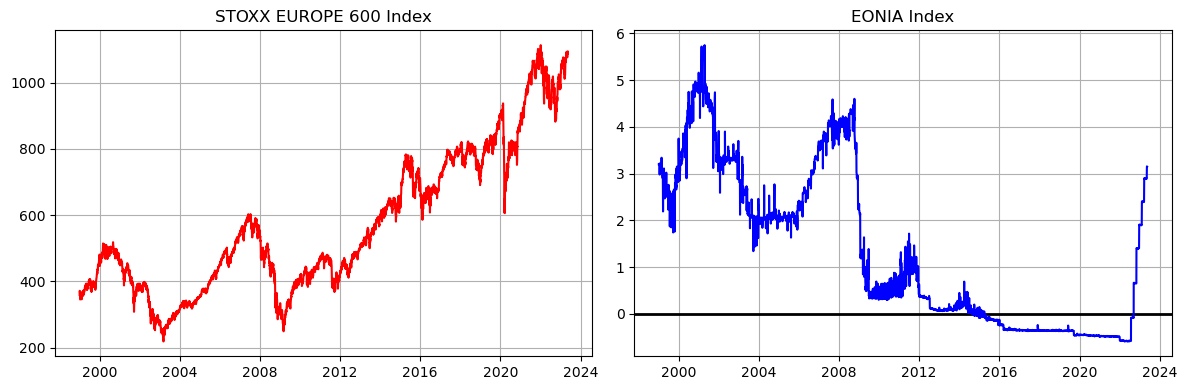

In [4]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(risk, c = "r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(rate, c = "blue")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [5]:
def investment_period(df:pd.DataFrame = risk, y0:Union[int,str]=2000, horizon:int=5, alldata:bool=False):
    """
    parameters:
        - df : The dataframe
        - y0 : The year, if str, or the date in which the investor start to invest
        - horizon : the period of investment.
        - alldata : a boolean variable.
    
    This function is used to get the dataset during an "investment period", denoted by IP.
        - If alldata is True, the IP start from y0 to the end of the dataset
        - If alldata is False, the IP start from y0 to the y0 to y0+horizon-1
        - If y0's type is int, we include the last day of the previous year into the dataset.
    """
    if (alldata == False):
        if type(y0)==int:
            # Only take the last day of past year
            table_investment_JN = pd.DataFrame(df[str(y0-1):str(y0-1)].iloc[-1]).T 
            # The period of investment
            table_investment_J = pd.DataFrame(df[str(y0):str(y0+horizon-1)])
            # concatenate
            table_investment = pd.concat([table_investment_JN, table_investment_J])
        elif type(y0)==str:
            yyyy = int(y0[:4]) # Give the 4 first letters from yyyy-mm-dd
            mm_dd = y0[4:] # Give the remaining -mm-dd
            yyyh_mm_dd = str(yyyy+horizon-1) + mm_dd
            table_investment = pd.DataFrame(df[y0:yyyh_mm_dd])
    else:
        if type(y0)==int:
            # Only take the last day of past year
            table_investment_JN = pd.DataFrame(df[str(y0-1):str(y0-1)].iloc[-1]).T
            table_investment_J = pd.DataFrame(df[str(y0):])
            table_investment = pd.concat([table_investment_JN, table_investment_J])
        elif type(y0)==str:
            table_investment = pd.DataFrame(df[y0:])        
    return table_investment

In [6]:
def returns(df:pd.DataFrame=risk, initial_investment:float=100.0, y0:Union[int,str]=2000,
           horizon:int=5, alldata:bool=False):
    """
    Parameters:
        - df : The DataFrame
        - initial_investment : The initial value that the client deposits 
        - y0 : The moment (year or day) when the client start to invest
        - horizon : The horizon of investment, by defaul 5 years
        - alldata : 
            - if True : Return the whole dataset from y0 to the end
            - if False : Return the y0 + horizon -1 results
    
    This function allows to compute at first, the returns of the risk asset, from y0 to y0+horizon-1 (if alldata = False)
    or from y0 to the end (if alldata = True). Those return will be apply to the initial amount the client choose to invest
    at beginning
    """
    data = investment_period(df, y0, horizon, alldata)
    S0 = float(data.iloc[0])
    stock_returns = [(float(data.iloc[x])/S0 -1) for x in range(len(data)) ]
    stock_returns = np.array(stock_returns).reshape(-1,1)
    data["Risk return"] = initial_investment * (1 + stock_returns)
    data = data.drop(data.columns[0],axis = 1)
    return data

In [7]:
def monetarize(df:pd.DataFrame=rate, initial_investment:float=100.0, y0:Union[int,str]=2000,
           horizon:int=5, alldata:bool=False):
    """
    parameters:
        - df : The dataset
        - initial_investment : The initial value that the client deposits 
        - y0 : The moment (year or day) when the client start to invest
        - horizon : The horizon of investment, by defaul 5 years
        - alldata : 
            - if True : Return the whole dataset from y0 to the end
            - if False : Return the y0 + horizon -1 results
            
    This function allows to compute the investment to the safe asset (bond), by starting with the amount the investor
    paid.
    """
    data = investment_period(df, y0, horizon, alldata)
    bond_rate = [x for x in data.iloc[:,0]]
    bond_rate = np.array(bond_rate).reshape(-1,1)
    bond = []
    compteur = 0
    for i in bond_rate:
        if compteur == 0:
            bond.append(initial_investment)
        else:
            investment = float(bond[compteur-1] * (1 + i/(365*100)))
            bond.append(investment)
        compteur += 1
    data["RiskFree return"] = bond
    data = data.drop(data.columns[0], axis = 1)
    return data

In [8]:
def createxls(df:pd.DataFrame, opt:bool=False):
    # XLS futures names 
    now = datetime.now()
    yyyy = str(now.year)
    mm = str(now.month).zfill(2)
    dd = str(now.day).zfill(2)
    hour = str(now.hour).zfill(2)
    minute = str(now.minute).zfill(2)
    second = str(now.second).zfill(2)
    name = f"DataFrame_{yyyy}_{mm}_{dd}_{hour}_{minute}_{second}"
    # Create excel
    work = xls.Workbook()
    feuille = work.active #take the first sheet by default
    # Path
    path = os.getcwd()
    full_name = path + "\\01. Excel Data\\" + name +".xlsx"
    #Save :
    work.save(full_name)
    work.close()
    # Updated 
    df.to_excel(full_name, index = opt)
    print(f"The following excel is successfuly registered : {name}")

<AxesSubplot:>

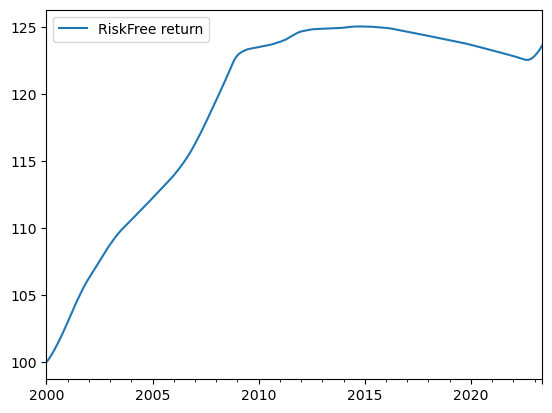

In [9]:
monetarize(alldata = True).plot()

<AxesSubplot:>

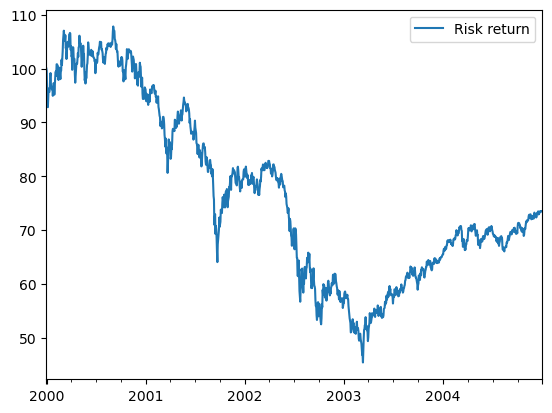

In [10]:
returns(initial_investment = 100).plot()

In [11]:
class Information:
    def __init__(self, dfrisk:pd.DataFrame=risk, dfrate:pd.DataFrame=rate, initial_investment:float=100.0, 
                 garant:float=1.0, y0:int=2000, horizon:int=5, multiplier:float=2, activation:list=[3,6,9,12]):
        self.dfrisk = dfrisk
        self.dfrate = dfrate
        self.initial_investment = initial_investment
        self.garant = garant
        self.y0 = y0
        self.horizon = horizon
        self.multiplier = multiplier
        self.activation = activation
        
        self.nb_days = len(self.dfrisk)
        self.nb_period_year = self.nb_days / self.horizon
        
    def check_period(self, opt:bool=False):
        """
        This method allows to give a screen about our data:
            - If opt is True: It returns the screen about risk asset
            - If opt is False: It returns the screen about free-risk asset
        Moreover, 
            - If y0 is an integer, it returns the screen of data from the latest value of the last year before the 
              investor starts to invest, to y0 + horizon - 1 (for instance : from 1999-12-31 to 2004-12-31 if investor 
              chooses to invest for 5 years)
            - If y0 is a str, it returns the screen of data from the date -y0- to -horizon- years after. 
        """
        if opt:
            tab = self.dfrisk
        else:
            tab = self.dfrate

        # Last rate of previous year
        tab_JN = pd.DataFrame(tab[str(self.y0-1):str(self.y0-1)].iloc[-1]).T
        # Rates from y0 to y0+horizon-1
        tab_J = tab[str(self.y0):str(self.y0 + self.horizon - 1)]
        # Concatenate
        table = pd.concat([tab_JN, tab_J])

        return table
    
    def pct_returns(self):
        tab = self.check_period(True)
        S0 = float(tab.iloc[0])
        stock_returns = [(float(tab.iloc[x])/S0 -1) for x in range(len(tab))]
        stock_returns = np.array(stock_returns).reshape(-1,1)
        tab["Risky return"] = self.initial_investment * (1 + stock_returns)
        tab = tab.drop(tab.columns[0],axis = 1)
        return tab
    
    def returns(self, col_name:str="Risk return"):
        tab = self.check_period(True)
        S0 = float(tab.iloc[0])
        stock_returns = [1.0] #100%
        for i in range(len(tab)):
            if i == 0 :
                pass
            else:
                stock_returns.append(float(tab.iloc[i])/float(tab.iloc[i-1]))
        stock_returns = np.array(stock_returns).reshape(-1,1)
        tab[col_name] = (stock_returns - 1) * 100 
        tab = tab.drop(tab.columns[0],axis = 1)
        return tab
    
    def constant_information(self):
        # Create constant information : Risk return, Rate, and Floor
        risk0 = self.returns("Risk return %")
        norisk0 = self.check_period(False)
        t = pd.DataFrame({"t":range(len(risk0))}, index = risk0.index)
        table = pd.concat([t, risk0, norisk0], axis = 1)
        return table
    


In [21]:
class CPPI(Information):
    def date_index(self):
        table = self.constant_information()#[0]
        nb_len = len(table)
        trim = [str(table.index[0])] # Last day of past year
        for year in range(self.y0,self.y0+self.horizon):
            for month in self.activation:
                yyyy = str(year)
                mm = str(month)
                yyyymm = yyyy + "-" + mm
                trim.append(str(table.loc[yyyymm].index[0]))
        last_part = table.loc[trim[-1]:].index[-1]
        trim.append(str(last_part))
        return trim
    
    def check_screen(self, data:pd.DataFrame, inception:str, end:str):
        return data.loc[inception:end]
    
    def garantide(self, value:float, opt:bool = True):
        if opt:
            self.garantia = value
        else:
            self.garantia = self.garant * self.initial_investment
            
    def liquidevalue(self, value:float, opt:bool = True):
        if opt:
            self.VL = value
        else:
            self.VL = self.initial_investment
    
    def garantie(self, value:float, inception:str, end:str, opt:bool = True):
        table = self.check_screen(self.constant_information(), inception, end)
        self.garantide(value,opt)
        table["Garantie"] = self.garantia
        return table
    
    def plancherie(self, value:float, inception:str, end:str, opt:bool = True):
        """
        This methods allows to compute the floor, which vary every day.
        In the C.P.P.I model, the floor is important.
        The floor's formula depend on the guaranteed capital (for instance, 100% of the initial investment) in which
        we should discounted it.
        """
        table = self.garantie(value, inception, end, opt)
        # Initialization
        r = list(table.iloc[:,2]) # norisk
        t = list(table.iloc[:,0]) # t
        garanteed_capital = list(table.iloc[:,3]) # Garantie
        planche = np.zeros((len(table),1))
        nb_period = self.nb_days/self.horizon # Business day, by mean
        
        for k in range(len(table)):
            planche[k] = garanteed_capital[k] / ((1 + (r[k]/100))**(self.horizon - t[k]/nb_period))
        
        table["Floor"] = planche
        return table
        
    def principale(self, value_garant:float, value_invest:float, inception:str, end:str, opt:bool = True):
        # Known data
        table = self.plancherie(value_garant, inception, end, opt)
        time = list(table.iloc[:,0])
        risk = list(table.iloc[:,1])
        norisk = list(table.iloc[:,2])
        plancher = list(table.iloc[:,4])
        
        # Initialization:

        val = [value_invest] #1
        cushion = [val[0] - plancher[0]] #2
        risky_before_adj = [cushion[0] * self.multiplier] #3
        norisk_before_adj = [val[0] - risky_before_adj[0]] #4
        multiplier_before_adj = [risky_before_adj[0] / cushion[0]] #5
        risky_adj = [risky_before_adj[0]] #6
        norisk_adj = [norisk_before_adj[0]] #7
        multiplier_adj = [self.multiplier] #8
        flow_adj = [0] #9     
        
        # Looping
        for t in range(len(table)):
            if t == 0:
                pass
            else:
                risky_before_adj.append(risky_adj[t-1] * (1 + risk[t]/100) ) 
                norisk_before_adj.append(norisk_adj[t-1] * (1 + norisk[t]/(100*self.nb_period_year)))   
                val.append(risky_before_adj[t] + norisk_before_adj[t])
                cushion.append(val[t] - plancher[t])
                multiplier_before_adj.append(risky_before_adj[t]/cushion[t])
                
                # if flow_adjustment > 0 : We have to buy the risky asset (financed by the safe asset), and reciprocally
                if (val[t-1] >= plancher[t-1]): # If liquidative Value is greater than the floor
                    # If m*C[t] - E[t] < B[t], which means that we can convert Bonds into Risky asset if we have to buy it
                    flow = 0
                    if (self.multiplier * cushion[t] - risky_before_adj[t] < norisk_before_adj[t]):
                        flow = self.multiplier * cushion[t] - risky_before_adj[t]
                    else: 
                        # Else, and if B[t] > 0, we only can buy the risky asset E[t] with an amount of B[t]€ (necessary but not sufficiency) 
                        if (norisk_before_adj[t] >= 0):
                            flow = norisk_before_adj[t]
                else: # If le Liquidative Value lower than the Floor, we decided to totally monetarize, i.e, 100% in Bonds
                    flow = -risky_before_adj[t]
                
                if (risky_before_adj[t] + flow > 0): #If the risk asset E[t] is high enough 
                    flow_adj.append(flow)
                else: # Else : We only can sell the amount of E[t] to get some B[t]
                    flow_adj.append(-risky_before_adj[t])
                risky_adj.append(risky_before_adj[t] + flow_adj[t])
                norisk_adj.append(norisk_before_adj[t] - flow_adj[t])
                multiplier_adj.append(risky_adj[t]/cushion[t])
        # Value attribution
        table["Liquidative Value"] = val
        table["Risk"] = risky_before_adj
        table["Safe asset"] = norisk_before_adj
        table["Cushion"] = cushion
        table["Multiplier before adj."] = multiplier_before_adj
        table["Flow Adjustment"] = flow_adj
        table["Risk with adj."] = risky_adj
        table["Safe Asset with adj."] = norisk_adj
        table["Multiplier with adj."] = multiplier_adj 
        return table
    
    def combined(self):
        # Preparation
        data_ind = self.date_index()
        list_data = []
        m = 0
        
        for i in range(len(data_ind)-1):
            if i == 0:
                self.garantide(self.garant * self.initial_investment, False) # Not obligation to enter an accurate Value, bcse False.
                data = self.principale(self.garantia, self.initial_investment, data_ind[i], data_ind[i+1], False)
                list_data.append(data[:-1])
            else:
                last_data = list_data[-1]
                last_VL = float(last_data.iloc[-1,5])
                last_VL_gar = last_VL * self.garant
                self.liquidevalue(last_VL, True)
                self.garantide(last_VL_gar, True)
                data = self.principale(self.garantia, self.VL, data_ind[i], data_ind[i+1], True)
                if i == len(data_ind)-2:
                    list_data.append(data)
                else:
                    list_data.append(data[:-1])
                
        return list_data
    
    def cppi(self):
        data_list = self.combined()
        data = pd.concat(data_list, axis = 0)
        data = data.drop(data.columns[0], axis = 1) #t
        return data
    
    def ploting(self):
        table = self.cppi()
        risk = self.pct_returns()
        tableVL = pd.DataFrame(table["Liquidative Value"])
        tableCoussin = pd.DataFrame(table["Cushion"])
        tablePlancher = pd.DataFrame(table["Floor"])
        
        return pd.concat([risk, tableVL, tableCoussin, tablePlancher], axis = 1)

<AxesSubplot:>

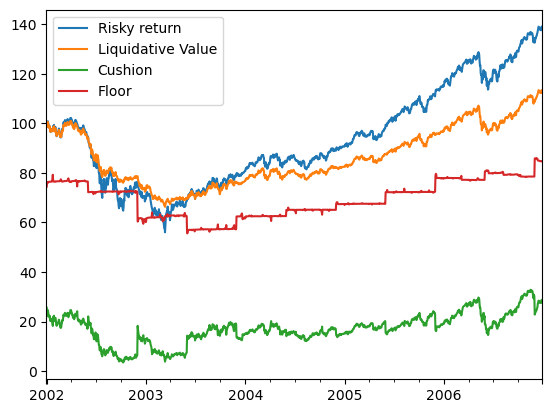

In [30]:
activation = [6,12]
cppi2000 = CPPI(dfrisk=risk, dfrate=rate, initial_investment=100.0, garant=0.9, y0=2002, horizon=5, multiplier=4, activation = activation)
information = cppi2000.cppi()
drawing = cppi2000.ploting()
drawing.plot()

In [31]:
drawing

,Risky return,Liquidative Value,Cushion,Floor
2001-12-31,100.000000,100.000000,25.705650,74.294350
2002-01-01,100.000000,99.999913,25.703322,74.296591
2002-01-02,98.512821,98.470682,22.137632,76.333050
2002-01-03,100.325641,100.100447,24.133479,75.966968
2002-01-04,100.825641,100.581647,24.612652,75.968995
...,...,...,...,...
2006-12-25,137.574359,112.211112,27.512028,84.699085
2006-12-26,137.574359,112.211175,27.509689,84.701486
2006-12-27,139.005128,113.355638,28.716690,84.638947
2006-12-28,139.061538,113.401639,28.695351,84.706288


In [32]:
createxls(information,True)

The following excel is successfuly registered : DataFrame_2024_01_05_22_23_32
